## Import Toolkit

In [96]:
#import os libs
import os
import shutil
import itertools
import pathlib
from PIL import Image
#import Data handling
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.metrics import confusion_matrix , classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
#import Deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense , BatchNormalization , Dropout,Flatten , Activation
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers
from keras.callbacks import ModelCheckpoint

#Warnings
import warnings
warnings.filterwarnings('ignore')

## Upload Data

In [97]:
root_dir = 'Dataset'
# Đường dẫn tới thư mục con 'train', 'val' và 'test'
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')
test_dir = os.path.join(root_dir, 'test')

### Tiền xử lí dữ liệu - Giảm chiều dữ liệu

In [98]:
img_size = (32 , 32)
batch_size = 8
img_shape = (img_size[0] , img_size[1] , 3)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_directory(train_dir , target_size = img_size , class_mode = 'categorical' ,
                                       color_mode = 'rgb' , shuffle = True , batch_size = batch_size)

valid_gen = ts_gen.flow_from_directory(val_dir , target_size = img_size , class_mode = 'categorical' ,
                                       color_mode = 'rgb' , shuffle = True , batch_size = batch_size)

test_gen = ts_gen.flow_from_directory(test_dir , target_size = img_size , class_mode = 'categorical' ,
                                       color_mode = 'rgb' , shuffle = False , batch_size = batch_size)

Found 1399 images belonging to 4 classes.
Found 397 images belonging to 4 classes.


Found 204 images belonging to 4 classes.


## Show Sample From Train Data
### Input đầu vào : 2.000 mẫu (có thể tăng lên 3.400 mẫu)

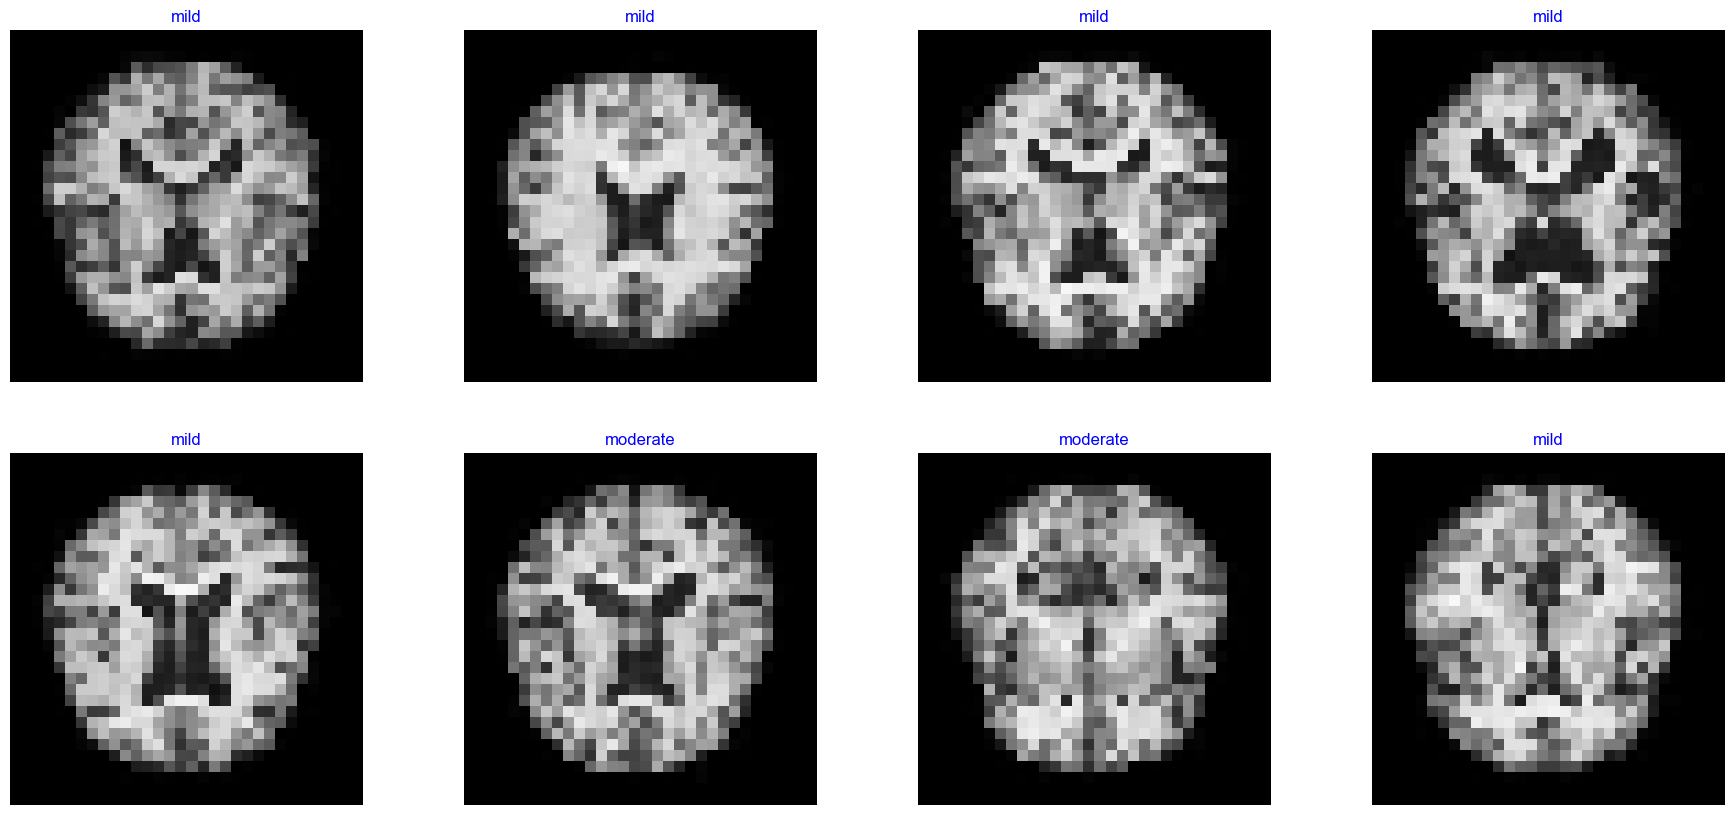

In [99]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)
num_samples = len(images)

plt.figure(figsize=(20, 20))

for i in range(min(16, num_samples)):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    # class_index = int(labels[i]) # binary 
    class_index = int(labels[i][0]) # categorical
    class_name = classes[class_index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()

## Model

In [100]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras import backend as K

def conv_bn_relu(x, filters, kernel_size, strides=(1, 1), padding='same'):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def grouped_convolution_block(x, filters, strides, cardinality):
    grouped_channels = filters // cardinality
    groups = []
    for i in range(cardinality):
        group = conv_bn_relu(x, grouped_channels, (1, 1))
        group = conv_bn_relu(group, grouped_channels, (3, 3), strides=strides)
        groups.append(group)
    x = Add()(groups)
    return x

def build_convnext(input_shape=(32, 32, 3), num_classes=10, cardinality=32):
    inputs = Input(shape=input_shape)
    
    # Initial Convolution
    x = conv_bn_relu(inputs, 64, (3, 3))
    
    # Stacking ConvNeXt blocks
    x = grouped_convolution_block(x, 128, strides=(2, 2), cardinality=cardinality)
    x = grouped_convolution_block(x, 256, strides=(2, 2), cardinality=cardinality)
    x = grouped_convolution_block(x, 512, strides=(2, 2), cardinality=cardinality)
    
    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)
    
    # Fully-connected layer
    # num_classes 
    num_classes = 4 # 4 nhãn  
    x = Dense(num_classes, activation='softmax')(x)
    
    # Create model
    model = Model(inputs, x, name='ConvNeXt')
    return model

# Create ConvNeXt model
convnext_model = build_convnext()

In [101]:
# convnext_model.summary()

## Compile and Fit Model

Thay thế các hàm tối ưu để đánh giá 
1. optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
2. optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
3. optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.01)
4. optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)
5. optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
6. optimizer = tf.keras.optimizers.Ftrl(learning_rate=0.001, learning_rate_power=-0.5, initial_accumulator_value=0.1, l1_regularization_strength=0.0, l2_regularization_strength=0.0)
7. optimizer = tf.keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
8. optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)


In [102]:
# Tạo đối tượng optimizer  # SGD
# optimizer = tf.keras.optimizers.Adam()
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.01)
# optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)
# optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# optimizer = tf.keras.optimizers.Ftrl(learning_rate=0.001, learning_rate_power=-0.5, initial_accumulator_value=0.1, l1_regularization_strength=0.0, l2_regularization_strength=0.0)
# optimizer = tf.keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)


# Thiết lập ModelCheckpoint
save_best_only = True
checkpoint = ModelCheckpoint('models/ConvNeXt_model-{epoch:03d}.keras',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=save_best_only,
                             mode='auto')

# Xây dựng quy trình huấn luyện
convnext_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Huấn luyện mô hình với dữ liệu đã chuẩn bị
H = convnext_model.fit(
    train_gen,
    steps_per_epoch = train_gen.samples // train_gen.batch_size,
    validation_data = valid_gen,
    validation_steps = valid_gen.samples // valid_gen.batch_size,
    epochs = 20,
    callbacks=[checkpoint]
)

Epoch 1/20


174/174 ━━━━━━━━━━━━━━━━━━━━ 94s 291ms/step - accuracy: 0.5081 - loss: 1.8400 - val_accuracy: 0.5026 - val_loss: 2.9088
Epoch 2/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7500 - loss: 0.3599 - val_accuracy: 0.2000 - val_loss: 3.5524
Epoch 3/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 49s 283ms/step - accuracy: 0.6223 - loss: 0.8652 - val_accuracy: 0.5434 - val_loss: 1.0528
Epoch 4/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8750 - loss: 0.1971 - val_accuracy: 0.6000 - val_loss: 0.6792
Epoch 5/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 50s 288ms/step - accuracy: 0.7384 - loss: 0.6317 - val_accuracy: 0.5918 - val_loss: 0.9565
Epoch 6/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7500 - loss: 0.2743 - val_accuracy: 0.4000 - val_loss: 0.4761
Epoch 7/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 51s 290ms/step - accuracy: 0.8344 - loss: 0.5035 - val_accuracy: 0.6046 - val_loss: 0.9231
Epoch 8/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8750 - loss: 0.2735 - val_accuracy: 1

## Model Performance

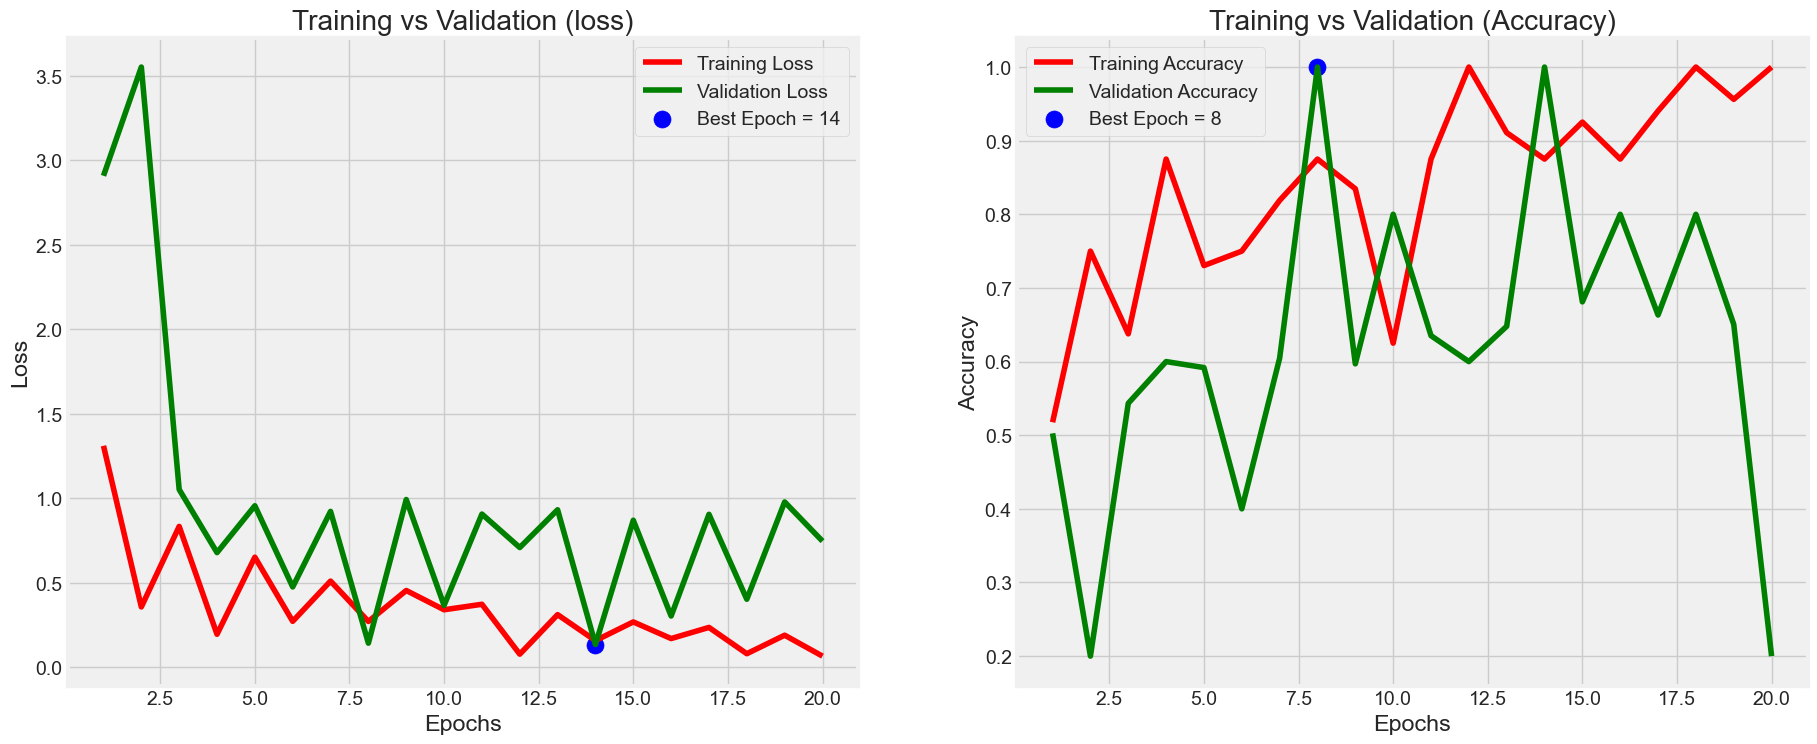

In [103]:
train_acc = H.history['accuracy']
train_loss = H.history['loss']

val_acc = H.history['val_accuracy']
val_loss = H.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r', label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss +1 , val_lowest , s = 150 , c = 'blue' , label = loss_label)
plt.title('Training vs Validation (loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r', label= 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s= 150 , c = 'blue' , label= acc_label)
plt.title('Training vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

## Model Evaluation

In [104]:
train_score = convnext_model.evaluate(train_gen , steps= 32 , verbose = 1)
val_score = convnext_model.evaluate(valid_gen , steps = 32 , verbose = 1)
test_score = convnext_model.evaluate(test_gen , steps = 32 , verbose = 1)

print(f'Train loss = {train_score[0] }')
print(f'Train Accuracy = {train_score[1]}')
print(f'Validation loss = {val_score[0]}')
print(f'Validation Accuracy = {val_score[1]}')
print(f'Test loss = {test_score[0]}')
print(f'Test Accuracy = {test_score[1]}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.9980 - loss: 0.1186
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.6850 - loss: 0.9560
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.6837 - loss: 0.7834
Train loss = 0.13611917197704315
Train Accuracy = 0.9921875
Validation loss = 0.9184668064117432
Validation Accuracy = 0.6796875
Test loss = 0.8357585072517395
Test Accuracy = 0.6470588445663452


In [105]:
from sklearn.metrics import classification_report, confusion_matrix

# Dự đoán
preds = convnext_model.predict(test_gen)
preds = np.argmax(preds, axis=1)

# Lấy nhãn thật
true_labels = test_gen.classes

# Tính các chỉ số
report = classification_report(true_labels, preds, output_dict=True)

# In chỉ số f1, precision, recall
print("F1:", report['weighted avg']['f1-score'])
print("Precision:", report['weighted avg']['precision'])
print("Recall:", report['weighted avg']['recall'])

26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step
F1: 0.6471123282893538
Precision: 0.668801091186712
Recall: 0.6470588235294118


In [106]:
print(classification_report(true_labels, preds))

              precision    recall  f1-score   support

           0       0.48      0.83      0.61        30
           1       0.00      0.00      0.00         3
           2       0.79      0.64      0.71       100
           3       0.61      0.61      0.61        71

    accuracy                           0.65       204
   macro avg       0.47      0.52      0.48       204
weighted avg       0.67      0.65      0.65       204



## Model Prediction

## Confusion Matrix and Classification Report

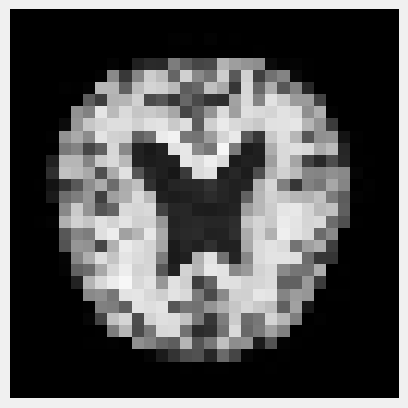

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Dự đoán: mild


In [112]:
# Lấy 1 batch dữ liệu từ generator
batch = next(test_gen)
# In hình ảnh đầu tiên
img = batch[0][0]
img = img.astype(float)/255
plt.imshow(img)
plt.axis('off')
plt.show()

# Chuyển đổi thành 4D tensor
img = np.expand_dims(img, axis=0)

# Dự đoán
pred = convnext_model.predict(img)
print('Dự đoán:', classes[np.argmax(pred)])

In [108]:
# Tính confusion matrix
conf_mat = confusion_matrix(true_labels, preds)

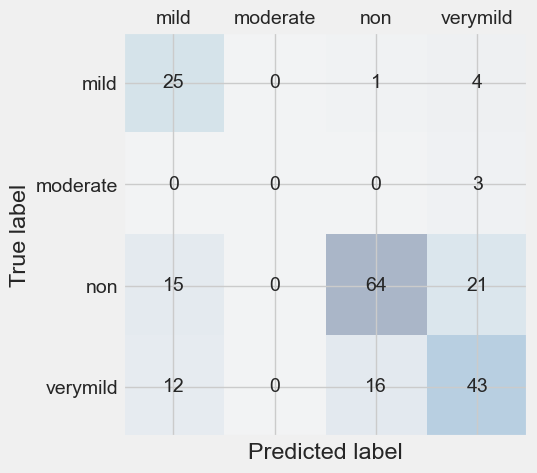

In [109]:
fig, ax = plt.subplots(figsize=(5,5))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i,s=conf_mat[i,j], va='center', ha='center')
# Set x and y labels as text
ax.set_xticklabels([''] + classes)
ax.set_yticklabels([''] + classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()